In [50]:
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning) 
warnings.filterwarnings('ignore','.*encoding is deprecated, Use raw=False instead..*')
warnings.filterwarnings('ignore','.*the matrix subclass is not the recommended way to represent matrices or deal with linear algebra.*')
warnings.filterwarnings('ignore','.*ill-defined.*')
warnings.filterwarnings('ignore','.*Data with input dtype int64 was converted to float64 by StandardScaler.*')

# importing required packages
from pathlib import Path

from collections import Counter

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

import spacy
nlp = spacy.load('en')

from spacy import displacy
#from spacy.lang.en import English
#parser = English()

#from tqdm import tqdm


from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.preprocessing import StandardScaler, MinMaxScaler, MaxAbsScaler
from sklearn.pipeline import Pipeline
from sklearn.base import BaseEstimator, TransformerMixin 

#from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.model_selection import GridSearchCV


from scipy.sparse import csr_matrix

np.random.seed(42)
%matplotlib inline

In [51]:
# set up display area to show dataframe in jupyter qtconsole

#pd.set_option('display.height', 1000)
#pd.set_option('display.max_rows', 500)
# pd.set_option('display.max_columns', 50)
#pd.set_option('display.width', 1000)
# pd.set_option('display.max_colwidth', -1)
# pd.reset_option('display.max_colwidth')

In [52]:
myDir = Path.cwd().parents[0]
dataFolder = myDir / 'data/asap-sas'
ratingsFolder = myDir / 'data/ratings'
figureFolder = myDir / 'figures'

print(dataFolder)

C:\Users\Devanshi\Desktop\finalProject\data\asap-sas


In [53]:
df = pd.read_csv(dataFolder/'training.csv', header=0)  #read data into dataframe
df.head(2)


,EssaySet,subject,studentGrade,EssayText,Score1,styleScore,totalChars,total_words,words_no_punct,words_no_punct_no_stop,count_content_words,count_stopwords,avg_word_len,maturity,concreteness,content_only_text,function_based_text,function_only_text,pos_tags
0,7,English,10,One trait that describes rose is hard-working....,1,1,120,27,23,12,15,11,4.173913,5.487419,2.449177,trait that describes rose is hard working...,one __NOUN__ __ADJ__ __VERB__ __VERB__ __VERB_...,"One - . I this because she to , but sh...",NUM NOUN ADJ VERB VERB VERB ADV PUNCT VERB PUN...
1,9,English,10,First the author has an introduction to grab t...,1,1,190,38,33,18,20,15,4.666667,5.333607,2.461765,First author has introduction grab reader...,__ADV__ the __NOUN__ __VERB__ an __NOUN__ to _...,"the an to the 's . , the if in the ...",ADV DET NOUN VERB DET NOUN PART VERB DET NOUN ...


In [54]:
# Take only essay set 1
df = df[~(df.subject == 'Biology')]
print(df.shape)

(10895, 19)


### X & Y Data

In [55]:
X = df[['EssayText','Score1']].copy()
X.reset_index(drop=True,inplace=True)
y= X.pop('Score1')

print(X.shape, y.shape)

(10895, 1) (10895,)


In [56]:
from sklearn.model_selection import KFold
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import precision_recall_fscore_support, cohen_kappa_score 
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
#from sklearn.metrics import accuracy_score, mean_squared_error, r2_score, cohen_kappa_score
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline, make_pipeline


## Global Experiment Parameters

In [57]:
#5-fold cross validation
kf = KFold(n_splits=5, shuffle=True)

In [58]:
def get_evaluation_metrics(y_test, y_pred):
    
    #macro-average will compute the metric independently for each class and then take the average (hence treating all classes equally)
    macro_precision, macro_recall, macro_fscore, _ = precision_recall_fscore_support(y_test, y_pred, average='macro')

    #micro-average will aggregate the contributions of all classes to compute the average metric
    micro_precision, micro_recall, micro_fscore, _ = precision_recall_fscore_support(y_test, y_pred, average='micro')

    #print(precision_recall_fscore_support(y_test, y_pred, average='weighted'))
    cohens_kappa = cohen_kappa_score(y_test, y_pred)
    
    return {'Macro_Precision':macro_precision, 'Macro_Recall': macro_recall,'Macro_fScore':macro_fscore,
             'Micro_Precision':micro_precision, 'Micro_Recall':micro_recall,'Micro_fScore':micro_fscore,
             'Cohens_Kappa':cohens_kappa}


### 1) Simple Baseline: Predict the most popular class

In [63]:

#Empty array to store results
tmp_results = []
results_columns = ['Subject','Model','Experiment',
                    'Macro_Precision','Macro_Recall','Macro_fScore',
                    'Micro_Precision','Micro_Recall','Micro_fScore',
                    'Cohens_Kappa']

#-----------------------------------------------------------------------------------------------------------------------------
#Per Subject experiment
#-----------------------------------------------------------------------------------------------------------------------------
experiment_name = 'Baseline_Content'
text_column = 'EssayText'


for subject in list(df.subject.unique()):
    
    X = df[(df['subject'] == subject)][[text_column,'Score1']].copy()
    X.reset_index(drop=True,inplace=True)
    y= X.pop('Score1')
    print(subject, X.shape, y.shape)
    target_names = [str(i) for i in sorted(y.unique())] #Convert to string
    
    y_test = []
    y_pred = []

    print('Cross Validating')
    # data is an array with our already pre-processed dataset examples
    for train_index, test_index in kf.split(X, y):

        #print("Train:", len(train_index), "Test:", len(test_index))
        fold_X_train, fold_X_test = X.reindex(train_index), X.reindex(test_index)
        fold_y_train, fold_y_test = y.reindex(train_index), y.reindex(test_index)
        
        most_common_class = Counter(fold_y_train).most_common(1)[0][0]
        
        ##For each fold, predict most common class as Baseline
        fold_y_pred = [most_common_class]* len(fold_y_test)

        y_test.extend(fold_y_test)
        y_pred.extend(fold_y_pred)


    print('Evaluating results')    
    
    myrow = {'Subject':subject, 'Model':None,'Experiment':experiment_name}
    myrow.update(get_evaluation_metrics(y_test, y_pred))
   
    tmp_results.append(myrow)

#-----------------------------------------------------------------------------------------------------------------------------
#Repeat experiment for overall
#-----------------------------------------------------------------------------------------------------------------------------

y_test = []
y_pred = []

print('\n')
print('Overall Results')
print("Train:", len(X), "Test:", len(y))
# data is an array with our already pre-processed dataset examples
for train_index, test_index in kf.split(X, y):

    
    fold_X_train, fold_X_test = X.reindex(train_index), X.reindex(test_index)
    fold_y_train, fold_y_test = y.reindex(train_index), y.reindex(test_index)

    most_common_class = Counter(fold_y_train).most_common(1)[0][0]

    ##For each fold, predict most common class as Baseline
    fold_y_pred = [most_common_class]* len(fold_y_test)

    y_test.extend(fold_y_test)
    y_pred.extend(fold_y_pred)


print('Evaluating results')    

myrow = {'Subject':'Overall', 'Model':None,'Experiment':experiment_name}
myrow.update(get_evaluation_metrics(y_test, y_pred))

tmp_results.append(myrow)

report = classification_report(y_test, y_pred, target_names=target_names)
print(report)
print("f1-macro: {:0.4f}  f1-micro: {:0.4f} \n".
              format(f1_score(y_test, y_pred, average='macro'),f1_score(y_test, y_pred, average='micro')))

###################################################################################################
# Get results, in a  DataFrame
simple_baseline_results = pd.DataFrame(tmp_results, columns=results_columns)
simple_baseline_results



English (4296, 1) (4296,)
Cross Validating
Evaluating results
Science (3666, 1) (3666,)
Cross Validating
Evaluating results
English Language Arts (2933, 1) (2933,)
Cross Validating
Evaluating results


Overall Results
Train: 2933 Test: 2933
Evaluating results
             precision    recall  f1-score   support

          0       0.00      0.00      0.00       902
          1       0.54      1.00      0.70      1571
          2       0.00      0.00      0.00       460

avg / total       0.29      0.54      0.37      2933

f1-macro: 0.2325  f1-micro: 0.5356 



,Subject,Model,Experiment,Macro_Precision,Macro_Recall,Macro_fScore,Micro_Precision,Micro_Recall,Micro_fScore,Cohens_Kappa
0,English,None,Baseline_Content,0.117086,0.333333,0.173299,0.351257,0.351257,0.351257,0.000000
1,Science,None,Baseline_Content,0.166070,0.246778,0.179155,0.334970,0.334970,0.334970,-0.006606
2,English Language Arts,None,Baseline_Content,0.178543,0.333333,0.232534,0.535629,0.535629,0.535629,0.000000
3,Overall,None,Baseline_Content,0.178543,0.333333,0.232534,0.535629,0.535629,0.535629,0.000000


## Baseline per Model

In [30]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm  import LinearSVC
from sklearn.ensemble import RandomForestClassifier

# from imblearn.over_sampling import SMOTE
# from imblearn.pipeline import make_pipeline, Pipeline

from sklearn.pipeline import Pipeline, make_pipeline

random_state = 42


In [64]:
#======================EXPERIMENT CONFIG===================
experiment_name = 'Baseline_perModel_Content'
text_column = 'EssayText'

#Empty array to store results
tmp_results = []
results_columns = ['Subject','Model','Experiment',
                    'Macro_Precision','Macro_Recall','Macro_fScore',
                    'Micro_Precision','Micro_Recall','Micro_fScore',
                    'Cohens_Kappa']

#Models and Vectorisers
count_vectorizer = CountVectorizer()
models = [('LogR', LogisticRegression(random_state=random_state)),
         ('NB', MultinomialNB()),
          ('SVM',LinearSVC(random_state=random_state)),
         ('RF',RandomForestClassifier(random_state=random_state))]

#-----------------------------------------------------------------------------------------------------------------------------
#Per Subject experiment
#-----------------------------------------------------------------------------------------------------------------------------

for subject in list(df.subject.unique()):
    print('\n=========={}==========='.format(subject))
    
    X = df[(df['subject'] == subject)][[text_column,'Score1']].copy()
    X.reset_index(drop=True,inplace=True)
    y= X.pop('Score1')
    print(subject, X.shape, y.shape)
    target_names = [str(i) for i in sorted(y.unique())] #Convert to string
    
    # For each model
    for model_name, clf in models:
        print('\n------------{}-------------'.format(model_name))

        y_test = []
        y_pred = []

        print('Cross Validating...')
        # data is an array with our already pre-processed dataset examples
        for train_index, test_index in kf.split(X, y):

            #print("Train:", len(train_index), "Test:", len(test_index))
            fold_X_train, fold_X_test = X.reindex(train_index), X.reindex(test_index)
            fold_y_train, fold_y_test = y.reindex(train_index), y.reindex(test_index)

            fold_X_train = fold_X_train[text_column]
            fold_X_test =  fold_X_test[text_column]

            #Make pipeline to train classifier
            pipe = make_pipeline(count_vectorizer, clf)
            pipe.fit(fold_X_train, fold_y_train)

            # Evaluate on validation set
            fold_y_pred = pipe.predict(fold_X_test)

            y_test.extend(fold_y_test)
            y_pred.extend(fold_y_pred)


        print('Evaluating results...')    

        myrow = {'Subject':subject, 'Model':model_name, 'Experiment':experiment_name}
        myrow.update(get_evaluation_metrics(y_test, y_pred))

        tmp_results.append(myrow)
        
        report = classification_report(y_test, y_pred, target_names=target_names)
        print(report)
        print("f1-macro: {:0.4f}  f1-micro: {:0.4f}".
              format(f1_score(y_test, y_pred, average='macro'),f1_score(y_test, y_pred, average='micro')))

    #     conf_mat = confusion_matrix(y_test, y_pred)
    #     fig, ax = plt.subplots(figsize=(5,5))
    #     sns.heatmap(conf_mat, annot=True, fmt='d', xticklabels=target_names, yticklabels=target_names, cmap="YlGnBu")

    #     plt.title('Set {}: {}'.format(str(essay_set),model_name))
    #     plt.ylabel('Actual Class')
    #     plt.xlabel('Predicted Class')

    #     print(figureFolder/"baseline_content/{}_{}_Set{}.svg".format(model_name, experiment_name, str(essay_set)))
    #     plt.savefig(figureFolder/"baseline_content/{}_{}_Set{}.svg".format(model_name, experiment_name, str(essay_set))", 
    #                 format="svg", bbox_inches='tight')
        #plt.show()


###################################################################################################
# Get results, in a  DataFrame
baseline_mdl_results = pd.DataFrame(tmp_results, columns=results_columns)
baseline_mdl_results              


==========English===========
English (4296, 1) (4296,)

------------LogR-------------
Cross Validating...
Evaluating results...
             precision    recall  f1-score   support

          0       0.68      0.75      0.72      1509
          1       0.55      0.48      0.51      1340
          2       0.70      0.69      0.69      1447

avg / total       0.64      0.65      0.65      4296

f1-macro: 0.6411  f1-micro: 0.6490

------------NB-------------
Cross Validating...
Evaluating results...
             precision    recall  f1-score   support

          0       0.55      0.56      0.56      1509
          1       0.49      0.36      0.41      1340
          2       0.52      0.63      0.57      1447

avg / total       0.52      0.52      0.52      4296

f1-macro: 0.5135  f1-micro: 0.5228

------------SVM-------------
Cross Validating...
Evaluating results...
             precision    recall  f1-score   support

          0       0.67      0.70      0.68      1509
          1    

,Subject,Model,Experiment,Macro_Precision,Macro_Recall,Macro_fScore,Micro_Precision,Micro_Recall,Micro_fScore,Cohens_Kappa
0,English,LogR,Baseline_perModel_Content,0.641345,0.643415,0.641070,0.648976,0.648976,0.648976,0.471675
1,English,NB,Baseline_perModel_Content,0.518820,0.518251,0.513462,0.522812,0.522812,0.522812,0.281052
2,English,SVM,Baseline_perModel_Content,0.610981,0.611997,0.611279,0.616387,0.616387,0.616387,0.423415
3,English,RF,Baseline_perModel_Content,0.580503,0.577888,0.574563,0.584032,0.584032,0.584032,0.372814
4,Science,LogR,Baseline_perModel_Content,0.567756,0.554236,0.560133,0.568467,0.568467,0.568467,0.394681
5,Science,NB,Baseline_perModel_Content,0.566796,0.512939,0.451400,0.453355,0.453355,0.453355,0.293901
6,Science,SVM,Baseline_perModel_Content,0.528255,0.524543,0.526295,0.534370,0.534370,0.534370,0.349979
7,Science,RF,Baseline_perModel_Content,0.527735,0.484609,0.495060,0.533824,0.533824,0.533824,0.333047
8,English Language Arts,LogR,Baseline_perModel_Content,0.510419,0.488845,0.493796,0.580975,0.580975,0.580975,0.264035
9,English Language Arts,NB,Baseline_perModel_Content,0.520430,0.522358,0.498051,0.522673,0.522673,0.522673,0.253380


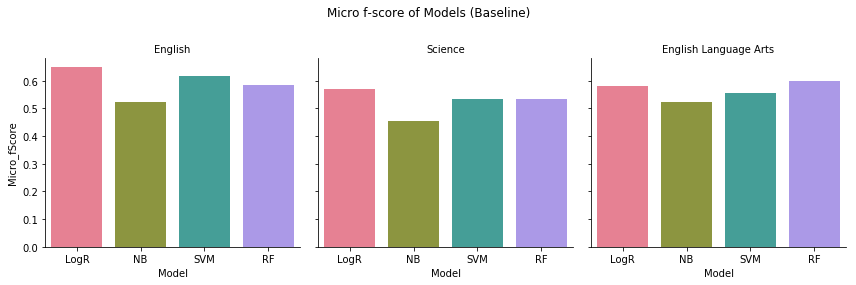

In [65]:
#Make plots
g = sns.catplot(x="Model", y="Micro_fScore", data=baseline_mdl_results, 
                col='Subject',hue="Model", kind="bar", 
                palette="husl", dodge=False, height=4)
g.set_titles(row_template = '{row_name}', col_template = '{col_name}')


plt.subplots_adjust(top=0.8)
g.fig.suptitle('Micro f-score of Models (Baseline)') # can also get the figure from plt.gcf()

plt.savefig(figureFolder/"baseline_content/Baseline_perModel_Content.svg", format="svg", bbox_inches='tight')

### Stopword Removal

In [101]:

#======================EXPERIMENT CONFIG===================
experiment_name = 'Removed_Stopword_perModel_Content'
text_column = 'EssayText'

#Empty array to store results
tmp_results = []
results_columns = ['Subject','Model','Experiment',
                    'Macro_Precision','Macro_Recall','Macro_fScore',
                    'Micro_Precision','Micro_Recall','Micro_fScore',
                    'Cohens_Kappa']

#Models and Vectorisers
# scaler = StandardScaler(with_mean=False)
count_vectorizer = CountVectorizer(stop_words='english')
models = [('LogR', LogisticRegression(random_state=random_state)),
         ('NB', MultinomialNB()),
          ('SVM',LinearSVC(random_state=random_state)),
         ('RF',RandomForestClassifier(random_state=random_state))]




#-----------------------------------------------------------------------------------------------------------------------------
#Per Subject experiment
#-----------------------------------------------------------------------------------------------------------------------------

for subject in list(df.subject.unique()):
    print('\n=========={}==========='.format(subject))
    
    X = df[(df['subject'] == subject)][[text_column,'Score1']].copy()
    X.reset_index(drop=True,inplace=True)
    y= X.pop('Score1')
    print(subject, X.shape, y.shape)
    target_names = [str(i) for i in sorted(y.unique())] #Convert to string
    
    
    # For each model
    for model_name, clf in models:
        print('\n------------{}-------------'.format(model_name))

        y_test = []
        y_pred = []

        print('Cross Validating...')
        # data is an array with our already pre-processed dataset examples
        for train_index, test_index in kf.split(X, y):

            #print("Train:", len(train_index), "Test:", len(test_index))
            fold_X_train, fold_X_test = X.reindex(train_index), X.reindex(test_index)
            fold_y_train, fold_y_test = y.reindex(train_index), y.reindex(test_index)

            fold_X_train = fold_X_train[text_column]
            fold_X_test =  fold_X_test[text_column]

            # Make pipeline to train classifier
            pipe = make_pipeline(count_vectorizer, clf)
            pipe.fit(fold_X_train, fold_y_train)

            # Evaluate on validation set
            fold_y_pred = pipe.predict(fold_X_test)

            y_test.extend(fold_y_test)
            y_pred.extend(fold_y_pred)


        print('Evaluating results...')    

        myrow = {'Subject':subject, 'Model':model_name, 'Experiment':experiment_name}
        myrow.update(get_evaluation_metrics(y_test, y_pred))

        tmp_results.append(myrow)
        
        report = classification_report(y_test, y_pred, target_names=target_names)
        print(report)
        print("f1-macro: {:0.4f}  f1-micro: {:0.4f}".
              format(f1_score(y_test, y_pred, average='macro'),f1_score(y_test, y_pred, average='micro')))

    #     conf_mat = confusion_matrix(y_test, y_pred)
    #     fig, ax = plt.subplots(figsize=(5,5))
    #     sns.heatmap(conf_mat, annot=True, fmt='d', xticklabels=target_names, yticklabels=target_names, cmap="YlGnBu")

    #     plt.title('Set {}: {}'.format(str(essay_set),model_name))
    #     plt.ylabel('Actual Class')
    #     plt.xlabel('Predicted Class')

    #     print(figureFolder/"baseline_content/{}_{}_Set{}.svg".format(model_name, experiment_name, str(essay_set)))
    #     plt.savefig(figureFolder/"baseline_content/{}_{}_Set{}.svg".format(model_name, experiment_name, str(essay_set))", 
    #                 format="svg", bbox_inches='tight')
        #plt.show()


###################################################################################################
# Get results, in a  DataFrame
no_stopword_results = pd.DataFrame(tmp_results, columns=results_columns)
no_stopword_results


==========English===========
English (4296, 1) (4296,)

------------LogR-------------
Cross Validating...
Evaluating results...
             precision    recall  f1-score   support

          0       0.68      0.76      0.72      1509
          1       0.55      0.47      0.51      1340
          2       0.68      0.68      0.68      1447

avg / total       0.64      0.64      0.64      4296

f1-macro: 0.6349  f1-micro: 0.6439

------------NB-------------
Cross Validating...
Evaluating results...
             precision    recall  f1-score   support

          0       0.58      0.58      0.58      1509
          1       0.51      0.36      0.42      1340
          2       0.53      0.67      0.59      1447

avg / total       0.54      0.54      0.54      4296

f1-macro: 0.5317  f1-micro: 0.5428

------------SVM-------------
Cross Validating...
Evaluating results...
             precision    recall  f1-score   support

          0       0.66      0.71      0.69      1509
          1    

,Subject,Model,Experiment,Macro_Precision,Macro_Recall,Macro_fScore,Micro_Precision,Micro_Recall,Micro_fScore,Cohens_Kappa
0,English,LogR,Removed_Stopword_perModel_Content,0.635608,0.637949,0.634926,0.643855,0.643855,0.643855,0.463738
1,English,NB,Removed_Stopword_perModel_Content,0.540228,0.537806,0.531736,0.542831,0.542831,0.542831,0.311022
2,English,SVM,Removed_Stopword_perModel_Content,0.610594,0.611531,0.610543,0.616155,0.616155,0.616155,0.422856
3,English,RF,Removed_Stopword_perModel_Content,0.607261,0.606664,0.604512,0.612197,0.612197,0.612197,0.416160
4,Science,LogR,Removed_Stopword_perModel_Content,0.565047,0.556521,0.560410,0.568740,0.568740,0.568740,0.396472
5,Science,NB,Removed_Stopword_perModel_Content,0.559098,0.516425,0.455340,0.454719,0.454719,0.454719,0.297216
6,Science,SVM,Removed_Stopword_perModel_Content,0.524618,0.520423,0.522237,0.533552,0.533552,0.533552,0.348562
7,Science,RF,Removed_Stopword_perModel_Content,0.522857,0.493062,0.501281,0.531097,0.531097,0.531097,0.334204
8,English Language Arts,LogR,Removed_Stopword_perModel_Content,0.526755,0.495593,0.500910,0.594613,0.594613,0.594613,0.280711
9,English Language Arts,NB,Removed_Stopword_perModel_Content,0.521697,0.510107,0.504907,0.549608,0.549608,0.549608,0.256706


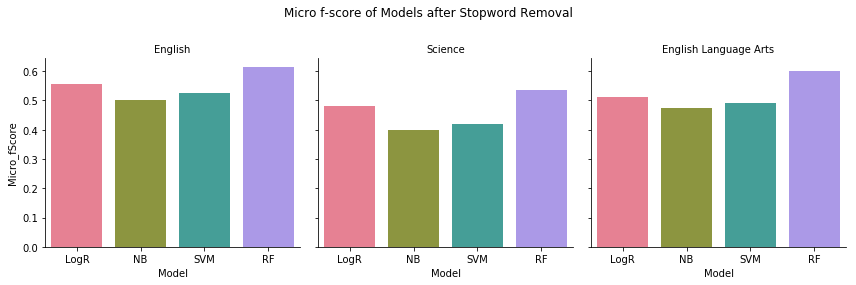

In [67]:
# Draw plots
g = sns.catplot(x="Model", y="Micro_fScore", data=no_stopword_results, 
                col='Subject',hue="Model", kind="bar", 
                palette="husl", dodge=False, height=4)
g.set_titles(row_template = '{row_name}', col_template = '{col_name}')

plt.subplots_adjust(top=0.8)
g.fig.suptitle('Micro f-score of Models after Stopword Removal') # can also get the figure from plt.gcf()

plt.savefig(figureFolder/"baseline_content/Stopword_Removal_Content.svg", format="svg", bbox_inches='tight')

## SMOTE Sampling (with stopword removal)

In [98]:
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import make_pipeline as imb_pipeline


from sklearn.metrics import f1_score

In [99]:
#======================EXPERIMENT CONFIG===================
experiment_name = 'SMOTE_perModel_Content'
text_column = 'EssayText'

#Empty array to store results
tmp_results = []
results_columns = ['Subject','Model','Experiment',
                    'Macro_Precision','Macro_Recall','Macro_fScore',
                    'Micro_Precision','Micro_Recall','Micro_fScore',
                    'Cohens_Kappa']

#Models and Vectorisers
smote = SMOTE(ratio='auto',random_state=random_state)
count_vectorizer = CountVectorizer(stop_words='english')
models = [('LogR', LogisticRegression(random_state=random_state)),
         ('NB', MultinomialNB()),
          ('SVM',LinearSVC(random_state=random_state)),
         ('RF',RandomForestClassifier(random_state=random_state))]


#-----------------------------------------------------------------------------------------------------------------------------
#Per Subject experiment
#-----------------------------------------------------------------------------------------------------------------------------

for subject in list(df.subject.unique()):
    print('\n=========={}==========='.format(subject))
    
    X = df[(df['subject'] == subject)][[text_column,'Score1']].copy()
    X.reset_index(drop=True,inplace=True)
    y= X.pop('Score1')
    
    target_names = [str(i) for i in sorted(y.unique())] #Convert to string

    print(subject, X.shape, y.shape)
    
    
    # For each model
    for model_name, clf in models:
        print('\n------------{}-------------'.format(model_name))

        y_test = []
        y_pred = []

        print('Cross Validating...')
        # data is an array with our already pre-processed dataset examples
        for train_index, test_index in kf.split(X, y):

#             print("Train:", len(train_index), "Test:", len(test_index))
            fold_X_train, fold_X_test = X.reindex(train_index), X.reindex(test_index)
            fold_y_train, fold_y_test = y.reindex(train_index), y.reindex(test_index)
            
            fold_X_train = fold_X_train[text_column]
            fold_X_test =  fold_X_test[text_column]
            
            # Make pipeline
            pipe = make_pipeline(count_vectorizer,smote, clf)
            pipe.fit(fold_X_train, fold_y_train)
            
            
            # Evaluate on validation set
            fold_y_pred = pipe.predict(fold_X_test)

            y_test.extend(fold_y_test)
            y_pred.extend(fold_y_pred)
            

        print('Evaluating results...')    

        myrow = {'Subject':subject, 'Model':model_name, 'Experiment':experiment_name}
        myrow.update(get_evaluation_metrics(y_test, y_pred))

        tmp_results.append(myrow)
        
        report = classification_report(y_test, y_pred, target_names=target_names)
        print(report)
        print("f1-macro: {:0.4f}  f1-micro: {:0.4f}".
              format(f1_score(y_test, y_pred, average='macro'),f1_score(y_test, y_pred, average='micro')))

    #     conf_mat = confusion_matrix(y_test, y_pred)
    #     fig, ax = plt.subplots(figsize=(5,5))
    #     sns.heatmap(conf_mat, annot=True, fmt='d', xticklabels=target_names, yticklabels=target_names, cmap="YlGnBu")

    #     plt.title('Set {}: {}'.format(str(essay_set),model_name))
    #     plt.ylabel('Actual Class')
    #     plt.xlabel('Predicted Class')

    #     print(figureFolder/"baseline_content/{}_{}_Set{}.svg".format(model_name, experiment_name, str(essay_set)))
    #     plt.savefig(figureFolder/"baseline_content/{}_{}_Set{}.svg".format(model_name, experiment_name, str(essay_set))", 
    #                 format="svg", bbox_inches='tight')
        #plt.show()


###################################################################################################
# Get results, in a  DataFrame
smote_sampling_results = pd.DataFrame(tmp_results, columns=results_columns)
smote_sampling_results              


==========English===========
English (4296, 1) (4296,)

------------LogR-------------
Cross Validating...
Evaluating results...
             precision    recall  f1-score   support

          0       0.69      0.75      0.72      1509
          1       0.55      0.50      0.53      1340
          2       0.68      0.68      0.68      1447

avg / total       0.64      0.65      0.65      4296

f1-macro: 0.6418  f1-micro: 0.6483

------------NB-------------
Cross Validating...
Evaluating results...
             precision    recall  f1-score   support

          0       0.57      0.56      0.57      1509
          1       0.50      0.38      0.43      1340
          2       0.53      0.65      0.58      1447

avg / total       0.53      0.54      0.53      4296

f1-macro: 0.5277  f1-micro: 0.5363

------------SVM-------------
Cross Validating...
Evaluating results...
             precision    recall  f1-score   support

          0       0.67      0.70      0.68      1509
          1    

,Subject,Model,Experiment,Macro_Precision,Macro_Recall,Macro_fScore,Micro_Precision,Micro_Recall,Micro_fScore,Cohens_Kappa
0,English,LogR,SMOTE_perModel_Content,0.641619,0.643344,0.641765,0.648277,0.648277,0.648277,0.470931
1,English,NB,SMOTE_perModel_Content,0.533327,0.532080,0.527713,0.536313,0.536313,0.536313,0.301769
2,English,SVM,SMOTE_perModel_Content,0.608938,0.609924,0.609245,0.614292,0.614292,0.614292,0.420298
3,English,RF,SMOTE_perModel_Content,0.612094,0.609638,0.607583,0.615223,0.615223,0.615223,0.420483
4,Science,LogR,SMOTE_perModel_Content,0.545957,0.573939,0.553788,0.556192,0.556192,0.556192,0.395599
5,Science,NB,SMOTE_perModel_Content,0.561699,0.517430,0.453971,0.450082,0.450082,0.450082,0.296828
6,Science,SVM,SMOTE_perModel_Content,0.506394,0.521487,0.512390,0.516367,0.516367,0.516367,0.333936
7,Science,RF,SMOTE_perModel_Content,0.525798,0.520029,0.522173,0.538189,0.538189,0.538189,0.354148
8,English Language Arts,LogR,SMOTE_perModel_Content,0.505812,0.524874,0.509368,0.547562,0.547562,0.547562,0.277355
9,English Language Arts,NB,SMOTE_perModel_Content,0.527080,0.539225,0.470389,0.468462,0.468462,0.468462,0.242549


#### Save results to Excel file

In [100]:
writer = pd.ExcelWriter(figureFolder/'baseline_content/Baseline_Content_Words_2.xlsx')
simple_baseline_results.to_excel(writer,'Simple_Baseline',index=False)
baseline_mdl_results.to_excel(writer,'Baseline_per_model',index=False)
no_stopword_results.to_excel(writer,'Removed_Stopwords',index=False)
smote_sampling_results.to_excel(writer,'Smote_perModel', index=False)
writer.save()

## FUNCTION BASED

In [83]:
X = set_1[['function_based_text','Score1']].copy()
X.reset_index(drop=True,inplace=True)
y= X.pop('Score1')

print(X.shape, y.shape)

#Initialise vectoriser
count_vectorizer = CountVectorizer()
clf = LogisticRegression() #OvR classifier
target_names = [str(i) for i in sorted(y.unique())] #Convert to string


# data is an array with our already pre-processed dataset examples
for train_index, test_index in skf.split(X, y):
    
    print("Train:", len(train_index), "Test:", len(test_index))
    X_train, X_test = X.reindex(train_index), X.reindex(test_index)
    y_train, y_test = y.reindex(train_index), y.reindex(test_index)
    
    #Make pipeline to train classifier
    pipe = make_pipeline(count_vectorizer, clf)
    pipe.fit(X_train['function_based_text'], y_train)
    
    #Make predictions on test data
    y_pred = pipe.predict(X_test['function_based_text'])
    
    print(precision_recall_fscore_support(y_test, y_pred, average='macro'))
    print(precision_recall_fscore_support(y_test, y_pred, average='micro'))
    print(precision_recall_fscore_support(y_test, y_pred, average='weighted'))
    print(cohen_kappa_score(y_test, y_pred))



(1339, 1) (1339,)
Train: 1069 Test: 270
(0.4535262298428251, 0.4392591015541835, 0.4329341058694658, None)
(0.44814814814814813, 0.44814814814814813, 0.44814814814814813, None)
(0.44540888919129373, 0.44814814814814813, 0.43417279772617495, None)
0.24774210437741917
Train: 1070 Test: 269
(0.3831232492997199, 0.3890151515151515, 0.38478021978021976, None)
(0.3940520446096654, 0.3940520446096654, 0.3940520446096654, None)
(0.386872221007362, 0.3940520446096654, 0.3891923689693206, None)
0.1832845940358001
Train: 1071 Test: 268
(0.42422500425821835, 0.41681792103478854, 0.4096899819898355, None)
(0.4291044776119403, 0.4291044776119403, 0.4291044776119403, None)
(0.4235424182104297, 0.4291044776119403, 0.4164891921006229, None)
0.2258283772302463
Train: 1073 Test: 266
(0.4558498399359744, 0.46317904468114, 0.4547386851944863, None)
(0.46616541353383456, 0.46616541353383456, 0.46616541353383456, None)
(0.45407817262243244, 0.46616541353383456, 0.45534104598512853, None)
0.27851317020992117


In [194]:
report = classification_report(y_test, y_pred, target_names=target_names)
print(report)
print("accuracy: {:0.3f}".format(accuracy_score(y_test, y_pred)))

             precision    recall  f1-score   support

          0       0.50      0.68      0.58       301
          1       0.32      0.25      0.28       348
          2       0.42      0.31      0.36       417
          3       0.38      0.47      0.42       273

avg / total       0.40      0.41      0.40      1339

accuracy: 0.412


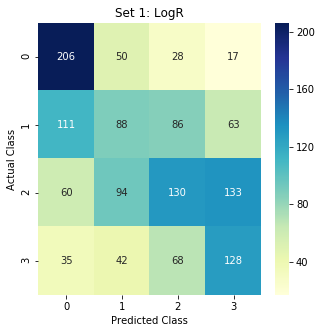

In [197]:

conf_mat = confusion_matrix(y_test, y_pred)
fig, ax = plt.subplots(figsize=(5,5))
sns.heatmap(conf_mat, annot=True, fmt='d', xticklabels=target_names, yticklabels=target_names, cmap="YlGnBu")

plt.title('Set {}: {}'.format('1','LogR'))
plt.ylabel('Actual Class')
plt.xlabel('Predicted Class')
plt.show()

### Concatenate Features & Prepare X & Y 

In [ ]:
X_train = pd.SparseDataFrame(data=merged_2, columns=feature_names)
X_train.head()

#X_train = csr_matrix(merged_2) 
# X_train

In [210]:
#y_train_tmp = pd.DataFrame(y_train_tmp)
# y_train_scaled = StandardScaler().fit_transform(y_train_tmp.astype(float))
# y_train_scaled = pd.DataFrame(y_train_scaled, index=y_train_tmp.index, columns=['Score1'])
# y_train = np.squeeze(y_train_scaled)


y_train = y_train_tmp

#print(X_train.shape)
print(y_train.shape)

(1170,)


In [211]:
print(text_ngrams_df.shape)

(1170, 264)


# CLASSIFICATION
## Feature Selection

In [7]:
from sklearn.feature_selection import SelectFromModel, SelectKBest, f_classif, mutual_info_classif
#from sklearn.linear_model import Lasso
#from sklearn.ensemble import ExtraTreesRegressor, GradientBoostingClassifier
from sklearn.svm import SVC

from sklearn.pipeline import Pipeline, make_pipeline


import eli5
from eli5.lime import TextExplainer

from yellowbrick.features.importances import FeatureImportances

C:\ProgramData\Anaconda3\envs\stylistics\lib\site-packages\sklearn\ensemble\weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


#### Univariate Selection
* Mutual Information

In [214]:
kBestmodel = SelectKBest(mutual_info_classif, k='all')
fit_data = kBestmodel.fit(text_ngrams_df, y_train)

In [222]:
feature_importance = list(zip(text_ngrams_columns, fit_data.scores_))
kBest_feature_importance = pd.DataFrame(feature_importance, columns=['feature','kBest_weight'])
kBest_feature_importance.sort_values(by='kBest_weight', ascending=False).head()

,feature,kBest_weight
108,__VERB__,0.087464
106,__NOUN__,0.078108
238,to,0.070309
105,__ADV__,0.057497
191,of,0.052992


In [224]:
kBest_feature_importance.sort_values(by='kBest_weight').head(10)

,feature,kBest_weight
263,zero,0.0
176,inside,0.0
178,it,0.0
92,8,0.0
181,materialinto,0.0
182,me,0.0
87,60minsand,0.0
188,no,0.0
84,5,0.0
83,4s,0.0


## 1) Baseline Model
* Logitistic Regression

In [8]:
from sklearn.linear_model import LogisticRegressionCV
from sklearn.pipeline import make_pipeline
from sklearn import metrics
from sklearn.metrics import confusion_matrix

In [19]:
def print_report(pipe, X, y, target_names):
    y_test = y
    y_pred = pipe.predict(X)
    report = metrics.classification_report(y_test, y_pred, target_names=target_names)
    print(report)
    print("accuracy: {:0.3f}".format(metrics.accuracy_score(y_test, y_pred)))

In [30]:
# We’re using LogisticRegressionCV here to adjust regularization parameter C automatically. 
# It allows to compare different vectorizers - optimal C value could be different for different input features 
# (e.g. for bigrams or for character-level input).
# An alternative would be to use GridSearchCV or RandomizedSearchCV.


#Initialise vectoriser
count_vectorizer = CountVectorizer()
clf = LogisticRegressionCV()
target_names = [str(i) for i in sorted(y_train_tmp.unique())] #Convert to string

pipe = make_pipeline(count_vectorizer, clf)
pipe.fit(train['EssayText'], y_train_tmp)

Pipeline(memory=None,
     steps=[('countvectorizer', CountVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 1), preprocessor=None, stop_words=None,
  ...2', random_state=None,
           refit=True, scoring=None, solver='lbfgs', tol=0.0001, verbose=0))])

In [31]:
print_report(pipe,train['EssayText'], y_train_tmp, target_names)

print_report(pipe,test['EssayText'], y_test_tmp, target_names)

             precision    recall  f1-score   support

          0       0.74      0.95      0.83       268
          1       0.94      0.43      0.59       309
          2       0.84      0.97      0.90       593

avg / total       0.84      0.82      0.80      1170

accuracy: 0.824
             precision    recall  f1-score   support

          0       0.79      0.89      0.84       112
          1       0.71      0.30      0.42       120
          2       0.78      0.94      0.85       270

avg / total       0.76      0.77      0.75       502

accuracy: 0.775


In [32]:
#Intercept (bias) feature is shown as <BIAS> in the same table. 
#We can inspect features and weights because we’re using a bag-of-words vectorizer and a linear classifier
#(so there is a direct mapping between individual words and classifier coefficients)

#eli5.show_weights(clf, top=10)
eli5.show_weights(clf, vec=count_vectorizer, top=15,  target_names=target_names)

In [33]:
eli5.show_prediction(clf, test['EssayText'][438], vec=count_vectorizer, target_names=target_names)

## Naive Bayes

In [53]:
from sklearn.naive_bayes import BernoulliNB, MultinomialNB

In [285]:

# def test_print_report(pipe):
#     y_test = y_test_tmp
#     y_pred = pipe.predict(test['EssayText'])
#     report = metrics.classification_report(y_test, y_pred,
#         target_names=target_names)
#     print(report)
#     print("accuracy: {:0.3f}".format(metrics.accuracy_score(y_test, y_pred)))


In [55]:
#Initialise vectoriser
clf = MultinomialNB()
pipe = make_pipeline(count_vectorizer, clf)
pipe.fit(train['EssayText'], y_train_tmp);
#MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)

In [57]:
print_report(pipe,train['EssayText'], y_train_tmp, target_names)

print_report(pipe,test['EssayText'], y_test_tmp, target_names)

             precision    recall  f1-score   support

          0       0.97      0.75      0.84       268
          1       0.81      0.58      0.68       309
          2       0.78      0.97      0.87       593

avg / total       0.83      0.82      0.81      1170

accuracy: 0.819
             precision    recall  f1-score   support

          0       0.86      0.50      0.63       112
          1       0.42      0.23      0.30       120
          2       0.70      0.96      0.81       270

avg / total       0.67      0.68      0.65       502

accuracy: 0.681


In [58]:
def print_top10(vectorizer, clf, class_labels):
    """Prints features with the highest coefficient values, per class"""
    feature_names = vectorizer.get_feature_names()
    for i, class_label in enumerate(class_labels):
        top10 = np.argsort(clf.coef_[i])[-10:]
        print("%s: %s" % (class_label, " ".join(feature_names[j] for j in top10)))

In [59]:
print_top10(count_vectorizer, clf, target_names)

0: experiment in would need mass of you and to the
1: and experiment how you in need would of to the
2: what vinegar know how in need would of to the


In [64]:
# It means that higher values mean more important features for the positive class.
# The above print shows the top 20 lowest values (less predictive features) in the first column 
#and the top 20 high values (highest predictive features) in the second column.

def show_most_informative_features(vectorizer, clf, n=20):
    feature_names = vectorizer.get_feature_names()
    coefs_with_fns = sorted(zip(clf.coef_[0], feature_names))
    top = zip(coefs_with_fns[:n], coefs_with_fns[:-(n + 1):-1])
    for (coef_1, fn_1), (coef_2, fn_2) in top:
        print("\t%.4f\t%-15s\t\t%.4f\t%-15s" % (coef_1, fn_1, coef_2, fn_2))
        
show_most_informative_features(count_vectorizer, clf, n=20)

	-9.2963	100            		-2.6005	the            
	-9.2963	100g           		-3.1849	to             
	-9.2963	100ml          		-3.7590	and            
	-9.2963	10cm           		-3.8847	you            
	-9.2963	10g            		-3.8847	of             
	-9.2963	11grams        		-3.9118	mass           
	-9.2963	1day           		-3.9350	need           
	-9.2963	1st            		-3.9980	would          
	-9.2963	1telling       		-4.0285	in             
	-9.2963	2days          		-4.2725	experiment     
	-9.2963	30min          		-4.4923	samples        
	-9.2963	3rd            		-4.5601	they           
	-9.2963	50g            		-4.6142	it             
	-9.2963	6th            		-4.6424	is             
	-9.2963	7grams         		-4.7320	for            
	-9.2963	above          		-4.7530	what           
	-9.2963	absolutely     		-4.7745	sample         
	-9.2963	absorb         		-4.7965	each           
	-9.2963	absorbed       		-4.8304	information    
	-9.2963	accuracy       		-4.8420	this           


In [284]:
#Initialise vectoriser
clf = BernoulliNB()
pipe = make_pipeline(count_vectorizer, clf)
pipe.fit(train['EssayText'], y_train);
#MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)

In [286]:
print_report(pipe,train['EssayText'], y_train, target_names)

print_report(pipe,test['EssayText'], y_test_tmp, target_names)

             precision    recall  f1-score   support

          0       0.65      0.61      0.63       268
          1       0.53      0.27      0.36       309
          2       0.68      0.86      0.76       593

avg / total       0.63      0.65      0.62      1170

accuracy: 0.649


             precision    recall  f1-score   support

          0       0.63      0.55      0.59       112
          1       0.41      0.16      0.23       120
          2       0.65      0.86      0.74       270

avg / total       0.59      0.63      0.59       502

accuracy: 0.625


## SVM

In [297]:
from sklearn.svm import SVC

In [66]:
#clf = svm.SVC(gamma='scale', decision_function_shape='ovo')
clf = SVC(kernel='linear', probability=True)
pipe = make_pipeline(count_vectorizer, clf)
pipe.fit(train['EssayText'], y_train_tmp)

Pipeline(memory=None,
     steps=[('countvectorizer', CountVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 1), preprocessor=None, stop_words=None,
  ...',
  max_iter=-1, probability=True, random_state=None, shrinking=True,
  tol=0.001, verbose=False))])

In [67]:
print_report(pipe,train['EssayText'], y_train_tmp, target_names)

print_report(pipe,test['EssayText'], y_test_tmp, target_names)

             precision    recall  f1-score   support

          0       0.96      1.00      0.98       268
          1       0.99      0.97      0.98       309
          2       0.99      0.98      0.98       593

avg / total       0.98      0.98      0.98      1170

accuracy: 0.982
             precision    recall  f1-score   support

          0       0.71      0.71      0.71       112
          1       0.46      0.49      0.48       120
          2       0.81      0.79      0.80       270

avg / total       0.70      0.70      0.70       502

accuracy: 0.699


In [68]:
te = TextExplainer(random_state=42)
te.fit(test['EssayText'][438], pipe.predict_proba)
te.show_prediction(target_names=target_names)

In [294]:
from sklearn.ensemble import RandomForestClassifier

In [295]:
clf = RandomForestClassifier()
pipe = make_pipeline(count_vectorizer, clf)
pipe.fit(train['EssayText'], y_train)

print_report(pipe,train['EssayText'], y_train, target_names)

print_report(pipe,test['EssayText'], y_test_tmp, target_names)

             precision    recall  f1-score   support

          0       0.99      1.00      0.99       268
          1       1.00      0.97      0.99       309
          2       0.99      1.00      0.99       593

avg / total       0.99      0.99      0.99      1170

accuracy: 0.991
             precision    recall  f1-score   support

          0       0.67      0.49      0.57       112
          1       0.24      0.20      0.22       120
          2       0.66      0.79      0.72       270

avg / total       0.56      0.58      0.56       502

accuracy: 0.580


In [296]:
eli5.show_weights(clf, vec=count_vectorizer, top=15,  target_names=target_names)

Weight,Feature
0.0732 ± 0.0558,__VERB__
0.0551 ± 0.0457,__ADV__
0.0512 ± 0.0356,__NOUN__
0.0501 ± 0.0396,to
0.0410 ± 0.0193,__ADJ__
0.0385 ± 0.0211,the
0.0374 ± 0.0178,of
0.0339 ± 0.0179,each
0.0319 ± 0.0210,in
0.0287 ± 0.0173,.


In [ ]:
import matplotlib.pyplot as plt

from sklearn.model_selection import StratifiedKFold
from sklearn.feature_selection import RFECV

In [ ]:
# Create the RFE object and compute a cross-validated score.
svc = SVC(kernel="linear")
# The "accuracy" scoring is proportional to the number of correct
# classifications
rfecv = RFECV(estimator=svc, step=1, cv=StratifiedKFold(2), scoring='accuracy')
rfecv.fit(X_train, y_train)



In [ ]:
print("Optimal number of features : %d" % rfecv.n_features_)

# Plot number of features VS. cross-validation scores
plt.figure()
plt.xlabel("Number of features selected")
plt.ylabel("Cross validation score (nb of correct classifications)")
plt.plot(range(1, len(rfecv.grid_scores_) + 1), rfecv.grid_scores_)
plt.show()

#### Tree Based 
* Random Forests
* GradientBoosted Trees

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import StratifiedKFold



rf_features = RFECV(RandomForestClassifier(n_estimators=100), cv=StratifiedKFold(5), scoring='f1_weighted')
rf_features.fit(X_train, y_train)
rf_features.poof()

In [ ]:
# Create a new matplotlib figure
# fig = plt.figure()
# ax = fig.add_subplot()

gb_model = GradientBoostingClassifier().fit(X_train, y_train)
feature_importances = gb_model.feature_importances_

eli5.show_weights(gb_model,feature_names=feature_names.tolist(), top=50, feature_filter=lambda x: x != '<BIAS>')

In [ ]:
clf = SVC(C=150, gamma=2e-2, probability=True)

pipe = make_pipeline(clf)
pipe.fit(X_train, y_train)
pipe.score(X_train, y_train)

In [ ]:
y_train.values

In [ ]:
dict(y_train.values)

In [ ]:
def print_prediction(doc):
    y_pred = pipe.predict_proba([doc])[0]
    #print(y_pred)
    for target, prob in zip(y_train, y_pred):
        print("{:.3f} {}".format(prob, target))

doc = X_train.loc[0,]
print_prediction(doc)

In [ ]:
# sparse_df = pd.SparseDataFrame(X_train)
# sparse_df.head()

sparse_df.fillna(0,inplace=True)
sparse_df.loc[0,].shape

In [ ]:
te = TextExplainer(random_state=42)
te.fit(doc, pipe.predict_proba)
te.show_prediction(target_names=twenty_train.target_names)

In [ ]:
eli5.show_prediction(gb_model, doc=train.iloc[1145,0], ve)